In [1]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm 
from matplotlib import pyplot as plt
import seaborn as sns

## Check inductive edge bank metrics

In [ ]:
data_name = 'uci'
def calculate_inductive_metric(data_name):
  node_feats = np.load(f'/home/ayush/DyGLib/processed_data/{data_name}/ml_{data_name}_node.npy')
  edge_feats = np.load(f'/home/ayush/DyGLib/processed_data/{data_name}/ml_{data_name}.npy')
  edge_data = pd.read_csv(f'/home/ayush/DyGLib/processed_data/{data_name}/ml_{data_name}.csv')

  num_nodes = node_feats.shape[0]
  node1 = torch.tensor(edge_data["u"].tolist())
  node2 = torch.tensor(edge_data["i"].tolist())
  ts = torch.tensor(edge_data["ts"].tolist())
  t_factor = 1
  pointer = 0
  min_time = ts[0]
  max_time = ts[-1]

  old_deg = torch.zeros(num_nodes)
  is_node_seen = torch.zeros(num_nodes, dtype = torch.bool)
  for max_cur_time_factor in torch.arange(0, 1/t_factor):
    while(ts[pointer] < min_time + (max_cur_time_factor+1)*t_factor*(max_time-min_time)):
      old_deg[node1[pointer]] += 1
      old_deg[node2[pointer]] += 1
      is_node_seen[node1[pointer]] = True
      is_node_seen[node2[pointer]] = True
      pointer += 1
    pointer2 = pointer
    is_node_seen2 = is_node_seen.copy()
    while(ts[pointer2] < min_time + (max_cur_time_factor+2)*t_factor*(max_time-min_time)):
      if is_node_seen2[node1[pointer2]]:
        neg_sample = torch.randint(0, num_nodes).item()
        pos_sample = node2
      else if is_node_seen2[node2[pointer2]]:
        
      
  count, deg = np.histogram(old_deg, bins = 10)
  count = torch.tensor(count)
  deg = torch.tensor(deg)[1:]
  sort_order = torch.argsort(count)
  # plt.stairs(count, deg)
  plt.plot(count[sort_order], deg[sort_order])
  plt.title(f'New Histogram for overall degree {data_name}')
  plt.xscale('log')
  plt.yscale('log')
  plt.xlabel('degree')
  plt.ylabel('count')
  plt.show()
  plt.close()

## Draw degree histogram

In [50]:
def draw_degree_hist(data_name):
  node_feats = np.load(f'/home/ayush/DyGLib/processed_data/{data_name}/ml_{data_name}_node.npy')
  edge_feats = np.load(f'/home/ayush/DyGLib/processed_data/{data_name}/ml_{data_name}.npy')
  edge_data = pd.read_csv(f'/home/ayush/DyGLib/processed_data/{data_name}/ml_{data_name}.csv')

  num_nodes = node_feats.shape[0]
  node1 = torch.tensor(edge_data["u"].tolist())
  node2 = torch.tensor(edge_data["i"].tolist())
  ts = torch.tensor(edge_data["ts"].tolist())
  t_factor = 1
  pointer = 0
  min_time = ts[0]
  max_time = ts[-1]

  old_deg = torch.zeros(num_nodes)
  is_node_seen = torch.zeros(num_nodes, dtype = torch.bool)
  for max_cur_time_factor in torch.arange(0, 1/t_factor):
    while(ts[pointer] < min_time + (max_cur_time_factor+1)*t_factor*(max_time-min_time)):
      old_deg[node1[pointer]] += 1
      old_deg[node2[pointer]] += 1
      is_node_seen[node1[pointer]] = True
      is_node_seen[node2[pointer]] = True
      pointer += 1
  count, deg = np.histogram(old_deg, bins = 10, range = (0, float(old_deg.max()//10)))
  count = torch.tensor(count)/count.sum()
  deg = torch.tensor(deg)[1:]
  sort_order = torch.argsort(deg)
  # plt.stairs(count, deg)
  return deg[sort_order], count[sort_order]

In [2]:
ALL_DATASETS = ['reddit', "ia-slashdot-reply-dir", "ia-digg-reply", "ia-retweet-pol", "ia-escorts-dynamic", "ia-movielens-user2tags-10m"]

In [52]:
# ALL_DATASETS = ["SocialEvo", "uci", "Flights", "CanParl", "USLegis", "UNtrade", "UNvote", "Contacts", "mooc", "wikipedia", "reddit", "enron", "myket"]
data = {}
for data_name in ALL_DATASETS:
  data[data_name] = draw_degree_hist(data_name)

In [53]:
data

{'reddit': (tensor([ 587.2000, 1174.4000, 1761.6000, 2348.8000, 2936.0000, 3523.2000,
          4110.3999, 4697.6001, 5284.7998, 5872.0000]),
  tensor([9.8122e-01, 1.2035e-02, 2.6441e-03, 1.3676e-03, 1.2764e-03, 4.5587e-04,
          0.0000e+00, 5.4705e-04, 4.5587e-04, 0.0000e+00])),
 'ia-slashdot-reply-dir': (tensor([ 33.5000,  67.0000, 100.5000, 134.0000, 167.5000, 201.0000, 234.5000,
          268.0000, 301.5000, 335.0000]),
  tensor([9.7080e-01, 1.7643e-02, 5.8352e-03, 2.3693e-03, 1.2532e-03, 9.3990e-04,
          5.0912e-04, 1.9581e-04, 3.1330e-04, 1.3707e-04])),
 'ia-digg-reply': (tensor([ 3.1000,  6.2000,  9.3000, 12.4000, 15.5000, 18.6000, 21.7000, 24.8000,
          27.9000, 31.0000]),
  tensor([0.6544, 0.1509, 0.0717, 0.0409, 0.0256, 0.0191, 0.0137, 0.0090, 0.0070,
          0.0077])),
 'ia-retweet-pol': (tensor([ 10.2000,  20.4000,  30.6000,  40.8000,  51.0000,  61.2000,  71.4000,
           81.6000,  91.8000, 102.0000]),
  tensor([0.8979, 0.0482, 0.0204, 0.0125, 0.0061, 0.0

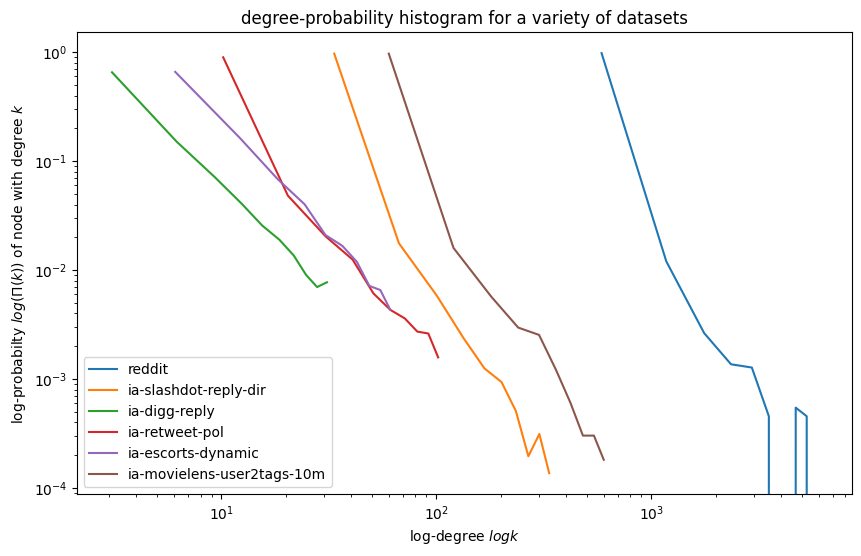

In [64]:
plt.figure(figsize=(10, 6))
for data_name, (deg, count) in data.items():  
  plt.plot(deg, count)
plt.title(f'degree-probability histogram for a variety of datasets')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'log-degree $log k$')
plt.ylabel(r'log-probabilty $log(\Pi(k))$ of node with degree $k$')
plt.legend(list(data.keys()))
plt.show()
plt.close()

In [7]:
def calculate_correlation(old_deg, new_node_new_deg):
  return float(torch.corrcoef(torch.cat((old_deg.unsqueeze(0), new_node_new_deg.unsqueeze(0)), dim = 0))[0, 1])

In [3]:
def calculate_all_correlations(node1, node2, ts, num_nodes, total_time, t1_factor = 0.05, t2_factor = 0.05):
  t1 = t1_factor * total_time
  t2 = t2_factor * total_time
  # indices corresponding to:
  p1 = 0  # start of the subgraph [t-t1-t2, t-t2)
  p2 = 0  # end of the subgraph [t-t1-t2, t-t2) and start of the subgraph [t-t2, t]
  p3 = 0  # end of the subgraph [t-t2, t]
  old_deg = torch.zeros(num_nodes)              # corresponds to the `degree` of each node in the subgraph [t-t1-t2, t-t2)
  new_node_new_deg = torch.zeros(num_nodes)     # corresponds to the `new node neighbor degree` of each node in the subgraph [t-t2, t]
  is_a_new_node = torch.ones(num_nodes, dtype=torch.bool)        # 1 if the node is unseen yet 0 otherwise
  is_a_new_node_edge = []   # stores is_a_new_node tuple for both the new nodes in [t-t2, t] subgraph
  correlations = []
  times = []
  is_first_time = True
  
  # Moving p3 from old timestamp to the next timestamp
  with tqdm(total=len(ts)) as pbar:
    while(p3 < len(ts)-1):
      if is_first_time:
        while(ts[p3] < t1 + t2):
          # Since this edge is entering the new subgraph [t-t2, t]
          # Add info to `is_a_new_node_edge` about whether the nodes are seen for the first time in this edge
          is_a_new_node_edge.append([is_a_new_node[node1[p3]], is_a_new_node[node2[p3]]])
          # If the nodes were unseen till now, then add 1 to the `new_node_new_deg` for the neighbour
          new_node_new_deg[node1[p3]] += int(is_a_new_node[node2[p3]])
          new_node_new_deg[node2[p3]] += int(is_a_new_node[node1[p3]])
          # Mark the nodes as seen
          is_a_new_node[node1[p3]] = False
          is_a_new_node[node2[p3]] = False
          # Move the counter ahead
          p3 += 1
          pbar.update(1)
        is_first_time = False
      else:
        # Since this edge is entering the new subgraph [t-t2, t]
        # Add info to `is_a_new_node_edge` about whether the nodes are seen for the first time in this edge
        is_a_new_node_edge.append([is_a_new_node[node1[p3]], is_a_new_node[node2[p3]]])
        # If the nodes were unseen till now, then add 1 to the `new_node_new_deg` for the neighbour
        new_node_new_deg[node1[p3]] += int(is_a_new_node[node2[p3]])
        new_node_new_deg[node2[p3]] += int(is_a_new_node[node1[p3]])
        # Mark the nodes as seen
        is_a_new_node[node1[p3]] = False
        is_a_new_node[node2[p3]] = False
        # Move the counter ahead
        p3 += 1
        pbar.update(1)
      
      while(ts[p2] < ts[p3]-t2):
        # Since this edge is going to the old subgraph [t-t1-t2, t-t2), add to the old_deg
        old_deg[node1[p2]] += 1
        old_deg[node2[p2]] += 1
        # Since this edge is coming from the new subgraph [t-t2, t]
        # If the other node was seen first at this edge (as indicated by the first element in `is_a_new_node_edge`, 
        # then remove 1 from the new_node_new_deg of this node)
        new_node_new_deg[node1[p2]] -= int(is_a_new_node_edge[0][1])
        new_node_new_deg[node2[p2]] -= int(is_a_new_node_edge[0][0])
        # Remove this edge from `is_a_new_node_edge` since it is no longer in the new subhraph [t-t2, t]
        is_a_new_node_edge = is_a_new_node_edge[1:]
        # Move the counter ahead
        p2 += 1
        
      while(ts[p1] < ts[p3]-t1-t2):
        # Since these edges are being removed from the old subgraph [t-t1-t2, t-t2), decrease old subgraph degree
        old_deg[node1[p1]] -= 1
        old_deg[node2[p1]] -= 1
        # Move the counter ahead
        p1 += 1
      
      correlations.append(calculate_correlation(old_deg, new_node_new_deg))
      times.append(ts[p3])
    return times, correlations

In [4]:
def calculate_correlation_plots(data_name = "wikipedia"):
  node_feats = np.load(f'/home/ayush/DyGLib/processed_data/{data_name}/ml_{data_name}_node.npy')
  num_nodes = node_feats.shape[0]
  edge_data = pd.read_csv(f'/home/ayush/DyGLib/processed_data/{data_name}/ml_{data_name}.csv')
  node1 = torch.tensor(edge_data["u"].tolist())
  node2 = torch.tensor(edge_data["i"].tolist())
  ts = torch.tensor(edge_data["ts"].tolist())
  
  # Check if they are sorted based on time
  new_ts = ts.clone().tolist()
  new_ts = sorted(new_ts)
  assert np.count_nonzero(np.array([new_ts[i] == ts[i] for i in range(len(ts))])) == len(ts)
  
  # Check if num_nodes is correct
  assert num_nodes == max(max(node1), max(node2)) + 1

  total_time = ts[-1] - ts[0]
  times, correlations = calculate_all_correlations(node1=node1, node2=node2, ts=ts, num_nodes=num_nodes, total_time=total_time, t1_factor = 0.2, t2_factor = 0.2)
  plt.plot(torch.arange(0, len(correlations)), correlations)
  plt.title(f'Correlation b/w old degree and new node neighbor degree for {data_name}')
  plt.show()

In [5]:
import bisect
from matplotlib import pyplot as plt
def find_rank(arr, x):
    # Sorting the array in descending order
    sorted_arr = sorted(arr)
    # Finding the proper insertion point for x
    idx_R = bisect.bisect_right(sorted_arr, x, lo=0, hi=len(sorted_arr))
    idx_L = bisect.bisect_left(sorted_arr, x, lo=0, hi=len(sorted_arr))
    return len(arr) - (idx_L + idx_R)//2 + 1

def calc_old_deg_ranks(data_name):
  node_feats = np.load(f'/home/ayush/DyGLib/processed_data/{data_name}/ml_{data_name}_node.npy')
  num_nodes = node_feats.shape[0]
  edge_data = pd.read_csv(f'/home/ayush/DyGLib/processed_data/{data_name}/ml_{data_name}.csv')
  node1 = torch.tensor(edge_data["u"].tolist())
  node2 = torch.tensor(edge_data["i"].tolist())
  # indices corresponding to:
  old_deg = torch.zeros(num_nodes)              # corresponds to the `degree` of each node in the subgraph [t-t1-t2, t-t2)
  is_new_node = torch.ones(num_nodes, dtype = torch.bool)
  record_old_deg_rank = []
  p = 0
  
  # Moving p3 from old timestamp to the next timestamp
  for p in tqdm(range(len(node1))):
    if is_new_node[node1[p]]:
      record_old_deg_rank.append(find_rank(old_deg, old_deg[node2[p]]))
    if is_new_node[node2[p]]:
      record_old_deg_rank.append(find_rank(old_deg, old_deg[node1[p]]))
    is_new_node[node1[p]] = False
    is_new_node[node2[p]] = False
    old_deg[node1[p]] += 1
    old_deg[node2[p]] += 1

  return record_old_deg_rank

In [6]:
import bisect
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from collections import defaultdict

def find_rank(running_sorted_list, x):
    # Finding the proper insertion point for x
    idx = bisect.bisect_right(running_sorted_list, x)
    # Calculate rank based on the length of the list
    return len(running_sorted_list) - idx + 1

def calc_old_deg_ranks(data_name):
    num_nodes_above_degree = defaultdict(lambda: 0)
    num_nodes_equal_degree = defaultdict(lambda: 0)
    node_feats = np.load(f'/home/ayush/DyGLib/processed_data/{data_name}/ml_{data_name}_node.npy')
    num_nodes = node_feats.shape[0]
    edge_data = pd.read_csv(f'/home/ayush/DyGLib/processed_data/{data_name}/ml_{data_name}.csv')
    node1 = torch.tensor(edge_data["u"].tolist())
    node2 = torch.tensor(edge_data["i"].tolist())
    num_nodes_equal_degree[0] = num_nodes
    
    old_deg = torch.zeros(num_nodes, dtype=torch.int)
    is_new_node = torch.ones(num_nodes, dtype=torch.bool)
    record_old_deg_rank = []
    
    for p in tqdm(range(len(node1))):
        node1_deg = old_deg[node1[p]].item()
        node2_deg = old_deg[node2[p]].item()
        assert (~is_new_node).sum() == num_nodes_above_degree[0]
        if node1[p] != node2[p]:

            # print(is_new_node[node1[p]], num_nodes_above_degree[0] > 0, node2_deg > 0)
            if is_new_node[node1[p]] and num_nodes_above_degree[0] > 0 and node2_deg > 0:
                record_old_deg_rank.append(max(num_nodes_above_degree[node2_deg] + num_nodes_equal_degree[node2_deg]/2 - 1, 0)/num_nodes_above_degree[0])
            
            # print(is_new_node[node2[p]], num_nodes_above_degree[0] > 0, node1_deg > 0)
            if is_new_node[node2[p]] and num_nodes_above_degree[0] > 0 and node1_deg > 0:
                record_old_deg_rank.append(max(num_nodes_above_degree[node1_deg] + num_nodes_equal_degree[node1_deg]/2 - 1, 0)/num_nodes_above_degree[0])
            
            num_nodes_above_degree[node1_deg] += 1
            num_nodes_above_degree[node2_deg] += 1
            num_nodes_equal_degree[node1_deg] -= 1
            num_nodes_equal_degree[node2_deg] -= 1
            num_nodes_equal_degree[node1_deg+1] += 1
            num_nodes_equal_degree[node2_deg+1] += 1
            is_new_node[node1[p]] = False
            is_new_node[node2[p]] = False
            old_deg[node1[p]] += 1
            old_deg[node2[p]] += 1
        
    return (torch.tensor(record_old_deg_rank, dtype=torch.float32))

In [7]:
ALL_DATASETS = ["ia-reality-call", "ia-digg-reply", "ia-escorts-dynamic", "ia-retweet-pol", "ia-slashdot-reply-dir", "ia-movielens-user2tags-10m"]
dct = {}

In [8]:
for dat in ALL_DATASETS:
    dct[dat] = calc_old_deg_ranks(dat)

100%|██████████| 95579/95579 [00:08<00:00, 11888.51it/s]


In [9]:
for dat in ["ia-digg-reply", "ia-escorts-dynamic", "ia-retweet-pol", "ia-reality-call", "ia-slashdot-reply-dir", "ia-movielens-user2tags-10m"]:
    print(f"{dat}: ", dct[dat].min().item(), dct[dat].max().item(), 1 - dct[dat].mean().item())

ia-digg-reply:  0.0 0.8086727261543274 0.759281188249588
ia-escorts-dynamic:  0.0 0.7929658889770508 0.7796542197465897
ia-retweet-pol:  0.0 0.730096161365509 0.8524523973464966
ia-reality-call:  0.0 0.7619616985321045 0.9726726617664099
ia-slashdot-reply-dir:  0.0 0.7480422854423523 0.830489382147789
ia-movielens-user2tags-10m:  0.0 0.7384598851203918 0.9085575118660927


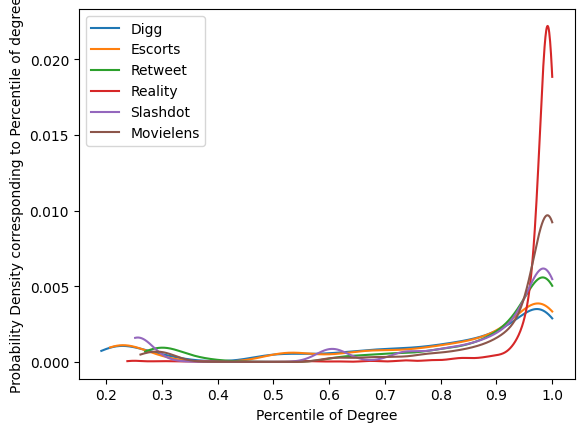

In [10]:
datasets = ["ia-digg-reply", "ia-escorts-dynamic", "ia-retweet-pol", "ia-reality-call", "ia-slashdot-reply-dir", "ia-movielens-user2tags-10m"]
from scipy.stats import gaussian_kde
plt.figure()
for dat in datasets:
    x = 1 - dct[dat]
    data_array = x.numpy()
    kde = gaussian_kde(data_array, bw_method='scott')
    
    # Create a range of values for flipper length
    x_vals = np.linspace(data_array.min(), data_array.max(), 1000)
    
    # Evaluate the KDE on this range
    kde_vals = kde(x_vals)
    
    # Normalize the KDE values so the area under the curve is 1
    kde_vals /= kde_vals.sum()
    
    # Plot the normalized KDE
    plt.plot(x_vals, kde_vals)

# Add labels and title
plt.xlabel('Percentile of Degree')
plt.ylabel('Probability Density corresponding to Percentile of degree')
plt.legend([dat.split("-")[1].capitalize() for dat in datasets])
plt.show()

In [16]:
torch.tensor([1 - dct[dat].mean().item() for dat in datasets]).mean()

tensor(0.8505)